In [ ]:
import os
import sys
sys.path.append("..")

from canon.common.init import init_logging
init_logging()

from canon.autoencode.report import backend_report
backend_report()

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm
from mpl_toolkits.axes_grid1 import Grid
from PIL import Image
%matplotlib inline

# import tensorflow as tf
# tf.config.optimizer.set_jit(False)           # turns off Auto-JIT for all graphs
# # For good measure you can also kill all XLA “experimental” opts:
# tf.config.optimizer.set_experimental_options({"disable_meta_optimizer": True})

import keras, keras.layers as L, keras.ops as K, keras.backend as B


from canon.autoencode.feeder import ImageDataFeeder

# IMAGE_DIR = os.path.join("img", "processed_981")
# TEST_DIR = os.path.join("img", "test_981")
IMAGE_DIR = os.path.join("..", "data", "mnt", "training")
TEST_DIR = os.path.join("..", "data", "mnt", "validation")
filenames = [filename for filename in os.listdir(IMAGE_DIR)]
IMAGE_SHAPE = (128, 128)
feeder = ImageDataFeeder(IMAGE_SHAPE, batch_size=30, training_dir=IMAGE_DIR, test_dir=TEST_DIR)
X_test = feeder.get_test_set()

2025-04-27 12:08:46,486 [MainThread] DEBUG h5py._conv:47 - Creating converter from 7 to 5
2025-04-27 12:08:46,487 [MainThread] DEBUG h5py._conv:47 - Creating converter from 5 to 7
2025-04-27 12:08:46,489 [MainThread] DEBUG h5py._conv:47 - Creating converter from 7 to 5
2025-04-27 12:08:46,489 [MainThread] DEBUG h5py._conv:47 - Creating converter from 5 to 7
2025-04-27 12:08:46,834 [MainThread] DEBUG matplotlib:342 - matplotlib data path: /home/ysong/projects/canon/venv/lib/python3.12/site-packages/matplotlib/mpl-data
2025-04-27 12:08:46,840 [MainThread] DEBUG matplotlib:342 - CONFIGDIR=/home/ysong/.config/matplotlib
2025-04-27 12:08:46,854 [MainThread] DEBUG matplotlib:1557 - interactive is False
2025-04-27 12:08:46,855 [MainThread] DEBUG matplotlib:1558 - platform is linux
2025-04-27 12:08:46,906 [MainThread] DEBUG matplotlib:342 - CACHEDIR=/home/ysong/.cache/matplotlib
2025-04-27 12:08:46,907 [MainThread] DEBUG matplotlib.font_manager:1635 - Using fontManager instance from /home/yson

In [2]:
def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + B.epsilon())
    return recall

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + B.epsilon())
    return precision

def f_beta(y_true, y_pred, beta=1):
    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    return (1 + beta**2)*((p*r)/((beta**2)*p+r+B.epsilon()))

In [3]:
import canon.autoencode
# from canon.autoencode import reset_tf_session
from canon.autoencode.models import load_encoder, load_decoder, load_autoencoder

# s = reset_tf_session()
model_name = "ae_conv_4_256_best"
encoder, decoder = load_autoencoder(model_name)
# encoder = load_encoder(model_name)
# decoder = load_decoder(model_name)
encoder.summary()
decoder.summary()

inp = L.Input(IMAGE_SHAPE)
code = encoder(inp)
reconstruction = decoder(code)
autoencoder = keras.models.Model(inputs=inp, outputs=reconstruction)
autoencoder.compile(optimizer="adam", loss='binary_crossentropy', metrics=['mse', f_beta])
reconstruction_mse = autoencoder.evaluate(X_test, X_test, verbose=1)
print("Convolutional Autoencoder Binary CrossEntropy:", reconstruction_mse)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape_1 (Reshape)             │ (None, 128, 128, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 16)   │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 64, 64, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64, 64, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │     2,097,408 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,194,560 (8.37 MB)

 Trainable params: 2,194,560 (8.37 MB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                 │ (None, 8192)           │     2,105,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_2 (Reshape)             │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 16, 16, 64)     │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 32, 32, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 64, 64, 16)     │         4,624 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 64, 64, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_4              │ (None, 128, 128, 1)    │           145 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_3 (Reshape)             │ (None, 128, 128)       │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,202,369 (8.40 MB)

 Trainable params: 2,202,369 (8.40 MB)

 Non-trainable params: 0 (0.00 B)

/home/ysong/projects/canon/venv/lib/python3.12/site-packages/keras/src/backend/common/backend_utils.py:91: UserWarning: You might experience inconsistencies across backends when calling conv transpose with kernel_size=3, stride=2, dilation_rate=1, padding=same, output_padding=1.
  warnings.warn(


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - f_beta: 8.7052e-05 - loss: 0.3466 - mse: 0.0139
Convolutional Autoencoder Binary CrossEntropy: [0.3685697615146637, 0.01563200354576111, 2.9054934202576987e-05]


2025-04-27 12:09:04,430 [MainThread] DEBUG matplotlib.font_manager:1471 - findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
2025-04-27 12:09:04,431 [MainThread] DEBUG matplotlib.font_manager:1483 - findfont: score(FontEntry(fname='/home/ysong/projects/canon/venv/lib/python3.12/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSansMono.ttf', name='DejaVu Sans Mono', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2025-04-27 12:09:04,432 [MainThread] DEBUG matplotlib.font_manager:1483 - findfont: score(FontEntry(fname='/home/ysong/projects/canon/venv/lib/python3.12/site-packages/matplotlib/mpl-data/fonts/ttf/cmsy10.ttf', name='cmsy10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2025-04-27 12:09:04,432 [MainThread] DEBUG matplotlib.font_manager:1483 - findfont: score(FontEntry(fname='/home/ysong/projects/canon/venv/lib/python3.12/site-packages/matplotli

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


2025-04-27 12:09:04,722 [MainThread] DEBUG matplotlib.font_manager:1471 - findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0.
2025-04-27 12:09:04,723 [MainThread] DEBUG matplotlib.font_manager:1483 - findfont: score(FontEntry(fname='/home/ysong/projects/canon/venv/lib/python3.12/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSansMono.ttf', name='DejaVu Sans Mono', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2025-04-27 12:09:04,723 [MainThread] DEBUG matplotlib.font_manager:1483 - findfont: score(FontEntry(fname='/home/ysong/projects/canon/venv/lib/python3.12/site-packages/matplotlib/mpl-data/fonts/ttf/cmsy10.ttf', name='cmsy10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2025-04-27 12:09:04,724 [MainThread] DEBUG matplotlib.font_manager:1483 - findfont: score(FontEntry(fname='/home/ysong/projects/canon/venv/lib/python3.12/site-packages/matplotli

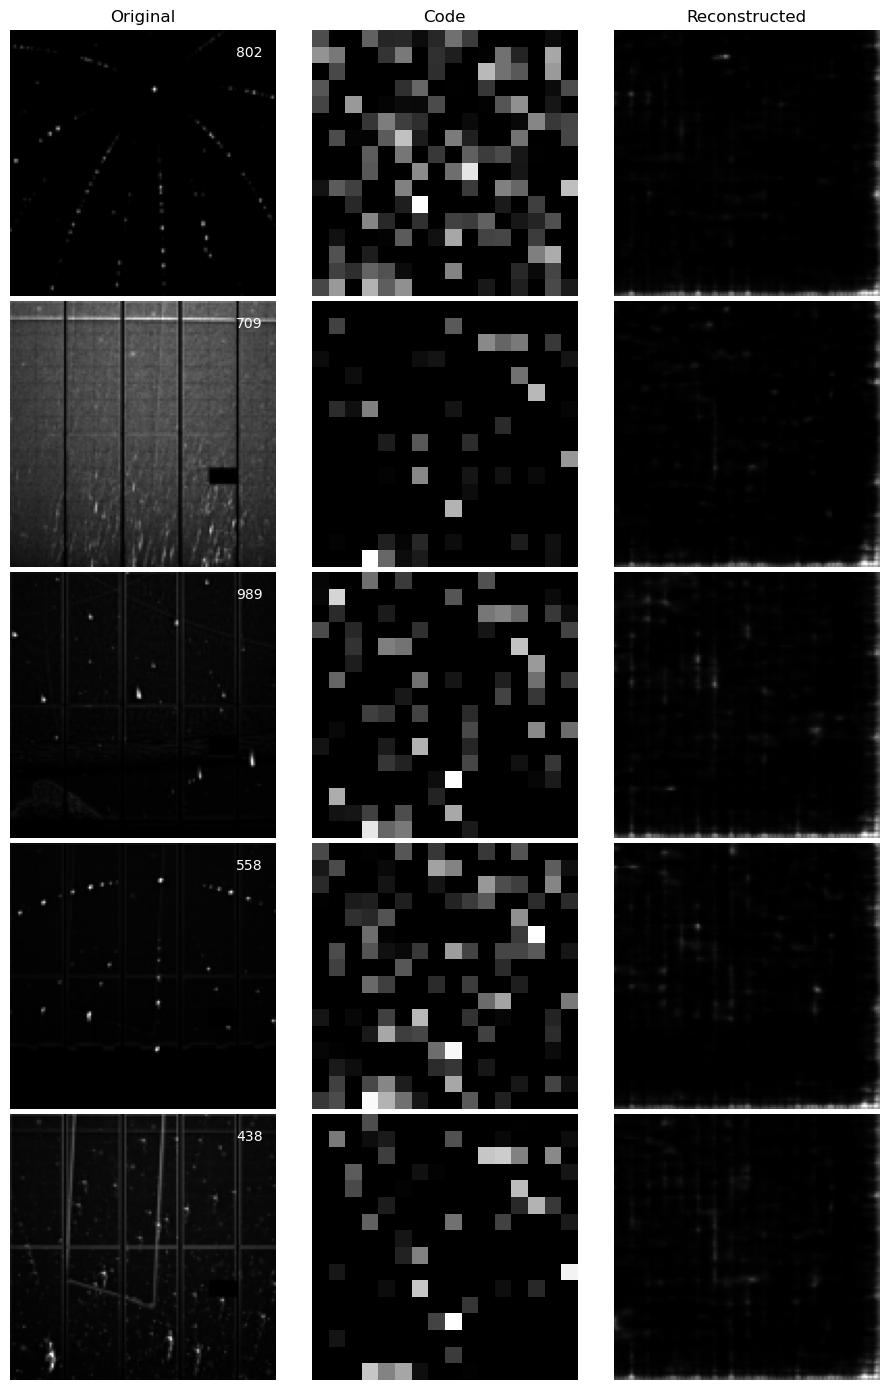

In [4]:
fig, ax = plt.subplots(5, 3, figsize=(10, 15))
for i, idx in enumerate(np.random.choice(len(X_test), 5)):
    img = X_test[idx]
    code = encoder.predict(img[None])[0]  # img[None] is the same as img[np.newaxis, :]
    reco = decoder.predict(code[None])[0]

    ax0 = ax[i, 0]
    ax0.imshow(img, cmap='gray')
    ax0.axis('off')

    ax1 = ax[i, 1] 
    if np.prod(code.shape) == 32:
        code_shape = (8, 4)
    elif np.prod(code.shape) == 128:
        code_shape = (16, 8)
    elif np.prod(code.shape) == 512:
        code_shape = (32, 16)
    else:
        code_shape = [int(np.ceil(np.sqrt(code.shape[-1]))),-1]
    ax1.imshow(code.reshape(code_shape), cmap='gray')
    ax1.axis('off')

    ax2 = ax[i, 2] 
    # plt.title("Reconstructed")
    ax2.imshow(reco, cmap='gray')
    ax2.axis('off')
    
    ax0.text(0.85, 0.9, "%d" % idx, color='w', fontsize=10, transform=ax0.transAxes)
    if i == 0:
        ax0.set_title(r'Original', fontsize=12)
        ax1.set_title(r'Code', fontsize=12)
        ax2.set_title(r'Reconstructed', fontsize=12)

fig.subplots_adjust(bottom=0, top=0.9, left=0, right=0.9, wspace=0.02, hspace=0.02)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


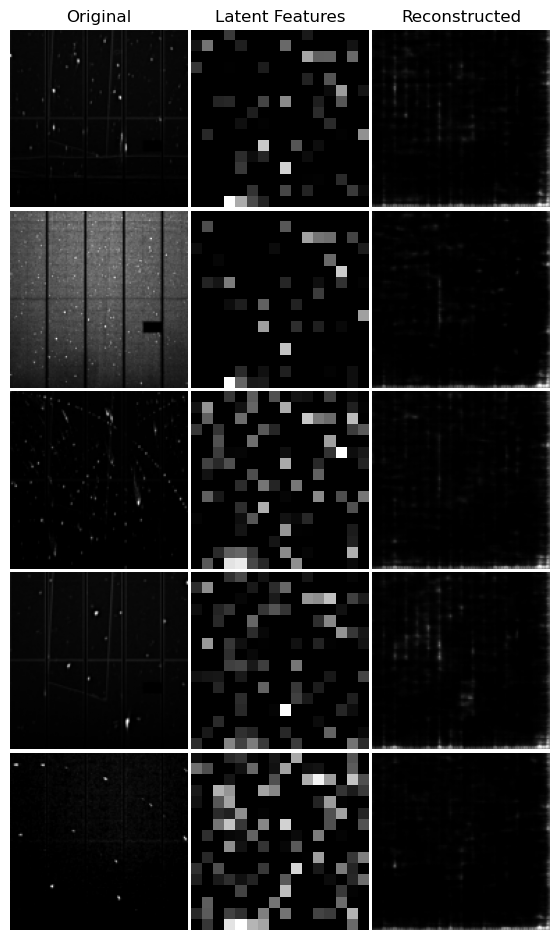

In [5]:
# image 96, 25, 99, 49, 64, 2
# image 35, 27, 17, 36, 79

fig, ax = plt.subplots(5, 3, figsize=(6, 10))
for i, idx in enumerate([35, 27, 17, 36, 79][:5]):
    img = X_test[idx]
    code = encoder.predict(img[None])[0]  # img[None] is the same as img[np.newaxis, :]
    reco = decoder.predict(code[None])[0]

    ax0 = ax[i, 0]
    ax0.imshow(img, cmap='gray')
    ax0.axis('off')

    ax1 = ax[i, 1] 
    if np.prod(code.shape) == 32:
        code_shape = (8, 4)
    elif np.prod(code.shape) == 128:
        code_shape = (16, 8)
    else:
        code_shape = [int(np.ceil(np.sqrt(code.shape[-1]))),-1]
    ax1.imshow(code.reshape(code_shape), cmap='gray')
    ax1.axis('off')

    ax2 = ax[i, 2] 
    ax2.imshow(reco, cmap='gray')
    ax2.axis('off')
    
    if i == 0:
        ax0.set_title(r'Original', fontsize=12)
        ax1.set_title(r'Latent Features', fontsize=12)
        ax2.set_title(r'Reconstructed', fontsize=12)

fig.subplots_adjust(bottom=0, top=0.9, left=0, right=0.9, wspace=0.02, hspace=0.02)
fig.savefig("img/review_model.pdf", bbox_inches='tight', dpi=300)

['epoch', 'loss', 'mse', 'val_loss', 'val_mse']


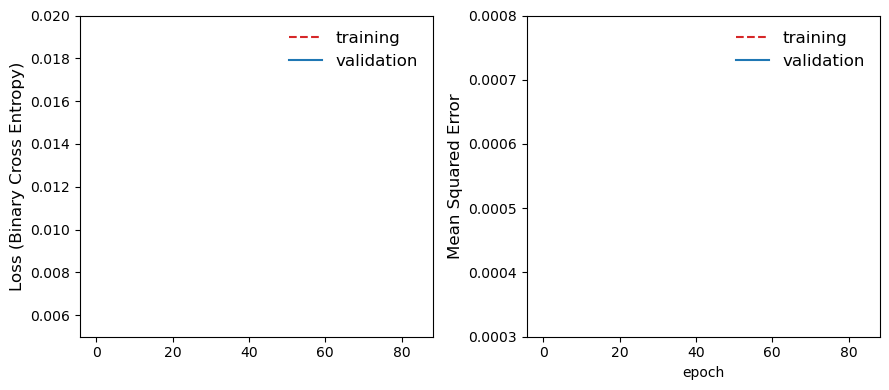

Exception ignored in: <function ResourceTracker.__del__ at 0x7f2530192d40>
Traceback (most recent call last):
  File "/home/ysong/projects/canon/venv/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/home/ysong/projects/canon/venv/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/home/ysong/projects/canon/venv/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x7fe37ef5ad40>
Traceback (most recent call last):
  File "/home/ysong/projects/canon/venv/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/home/ysong/projects/canon/venv/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/home/ysong/projects/canon/venv/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child proces

In [8]:
import csv

hist_csv = os.path.join("checkpoints", "conv_4", "256", "history.csv")
with open(hist_csv, 'r') as f_csv:
    reader = csv.reader(f_csv)
    headers = None
    X_data = []
    Y_data = []
    for row in reader:
        if headers is None:
            headers = row
            print(headers)
        else:
            X_data += [int(row[0])]
            Y_data += [[float(row[1]), float(row[2]), float(row[3]), float(row[4])]]

Y_data = np.array(Y_data)[15 : 15 + 200]
X_data = np.arange(Y_data.shape[0])

            
fig, ax = plt.subplots(1, 2, figsize=(9, 4))
ax[0].plot(X_data, Y_data[:, 0], label='training', color='tab:red', ls='--')
ax[0].plot(X_data, Y_data[:, 2], label='validation', color='tab:blue')
ax[0].set_ylim(0.005, 0.02)
ax[0].set_ylabel('Loss (Binary Cross Entropy)', fontsize=12)
ax[0].legend(frameon=False, fontsize=12)
ax[1].plot(X_data, Y_data[:, 1], label='training', color='tab:red', ls='--')
ax[1].plot(X_data, Y_data[:, 3], label='validation', color='tab:blue')
ax[1].set_ylim(3E-4, 8E-4)
ax[1].legend(frameon=False, fontsize=12)
ax[1].set_ylabel('Mean Squared Error', fontsize=12)
ax[1].set_xlabel('epoch')
plt.tight_layout()
fig.savefig("img/training_history.pdf", dpi=300)